In [1]:
%matplotlib inline

from collections import defaultdict
from typing import Dict, DefaultDict, List
from math import floor, log

def cdf(string : str, bins : int, alphabet : str, rate : int, method='flat', keep_history=False) -> DefaultDict[str, int]:
  alph_size = len(alphabet)
  cdf = init_cdf(string, alphabet, method, bins)
  history = defaultdict(list)
  for elem in alphabet:
    history[elem].append(cdf[elem])
  for ch in string:
    mx_cdf = mix_cdf(ch, bins, alphabet, alph_size)
    cdf = update_cdf(cdf, mx_cdf, alphabet, rate)
    if keep_history:
      for elem in alphabet:
        history[elem].append(cdf[elem])
  if keep_history:
    return cdf, history
  else:
    return cdf

def init_cdf(string : str, alphabet : str, method : str, bins : int) -> DefaultDict[str, int]:
  assert method in ('flat', 'avg'), "Wrong init method"
  cdf = defaultdict(int)
  alph_size = len(alphabet)
  str_len = len(string)
  if method == 'flat':
    uni = floor( (1 / alph_size) * bins)
    for i, elem in enumerate(alphabet):
      cdf[elem] = (i+1) * uni
  else:
    prev = 0
    for i, elem in enumerate(alphabet):
      cdf[elem] = prev + floor((string.count(elem) / str_len) * bins)
      prev = cdf[elem]
  return cdf

def mix_cdf(current_ch : str, bins : int, alphabet : str, alph_size : int) -> DefaultDict[str, int]:
  assert current_ch in alphabet, "Current char '{}' is not present in alphabet '{}'".format(current_ch, alphabet)
  mix_cdf = defaultdict(int)
  index = alphabet.index(current_ch)
  prev_val = 0
  for char in alphabet:
    mix_cdf[char] = prev_val + 1
    prev_val = mix_cdf[char]
    if char == current_ch:
      mix_cdf[char] = (bins - alph_size + 1)
    prev_val = mix_cdf[char]
  return mix_cdf

def update_cdf(cdf : DefaultDict[str, int], mx_cdf : DefaultDict[str, int], alphabet : str, rate : int) -> DefaultDict[str, int]:
  for elem in alphabet:
    cdf[elem] += (mx_cdf[elem] - cdf[elem]) >> rate
  return cdf

mx_cdf = mix_cdf('a', 8, 'abcd', 4)
print(mx_cdf)
print(mx_cdf['e'])
init_cdf('abcdbabdbc', 'abcd', method='avg', bins=8)

defaultdict(<class 'int'>, {'a': 5, 'b': 6, 'c': 7, 'd': 8})
0


defaultdict(int, {'a': 1, 'b': 4, 'c': 5, 'd': 6})

In [2]:
from math import log

example = "0014044010001001404441000010010000000000000000000000100000000000000000000000000000000000000000000000000"

bins = 1024
alphabet = "01234"
rate = 3
# alphabet = ''.join(set(example))
cdf_ = cdf(example, bins, alphabet, rate)
cdf_

defaultdict(int, {'0': 1013, '1': 1014, '2': 1015, '3': 1016, '4': 1020})

In [0]:
def steps_from_history(history : Dict[str, list], alphabet : str, n_steps : int) -> List[DefaultDict[str, int]]:
  dict_history = []
  for i in range(n_steps):
    step = defaultdict(int)
    for elem in history:
      step[elem] = history[elem][i]
    dict_history.append(step)
  return dict_history

def history_from_steps(steps : List[DefaultDict[str, int]]) -> DefaultDict[str, List[int]]:
  history = defaultdict(list)
  for step in steps:
    for sym, val in step.items():
      history[sym].append(val)
  return history

def get_prob_history(history : Dict[str, List[int]]) -> List[DefaultDict[str, float]]:
  steps = steps_from_history(history, alphabet, len(example))

  prob_history = []
  for i, step in enumerate(steps):
    prob_history.append(probs_from_cdf(step, bins))

  return history_from_steps(prob_history)

def probs_from_cdf(cdf : DefaultDict[str, int], bins : int) -> DefaultDict[str, float]:
  probs = defaultdict(float)
  prev = 0
  for elem, sub_cdf in cdf.items():
    probs[elem] = (sub_cdf - prev) / bins
    prev = sub_cdf
  return probs

def occurs_count_prob(string : str, alphabet : str) -> DefaultDict[str, float]:
  probs = defaultdict(float)
  str_len = len(string)
  for elem in alphabet:
    probs[elem] = string.count(elem) / str_len
  return probs

def kl_divergence(distrib1 : Dict[str, float], distrib2 : Dict[str, float]) -> float:
  sorted_X1 = list(sorted(distrib1.keys()))
  sorted_X2 = list(sorted(distrib2.keys()))
  assert sorted_X1 == sorted_X2, "Different distribution domain"
  divergence = 0
  for x1, x2 in zip(sorted_X1, sorted_X2):
    if distrib2[x2] == 0:
      continue
    divergence += distrib1[x1] * log(distrib1[x1] / distrib2[x2])
  return divergence

def mean_code_len(str_len : int, probs : Dict[str, float]) -> float:
  entropy = 0
  for prob in probs.values():
    if prob !=0:
      entropy += prob * log(1 / prob, 2)
  return str_len * entropy

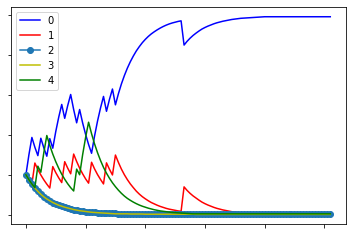

In [4]:
import numpy as np
import matplotlib.pyplot as plt

example = "0014044010001001404441000010010000000000000000000000100000000000000000000000000000000000000000000000000"
bins = 1024
alphabet = "01234"
rate = 3

cdf_, history = cdf(example, bins, alphabet, rate, keep_history=True)

hist = get_prob_history(history)
styles = ['b-', 'r-', 'o-', 'y-', 'g-']

def draw_plot(history : Dict[str, List], alphabet : str, styles : List[str], zoom=0) -> None:
  if zoom == 0:
    zoom = len(history[alphabet[0]])
  fig, ax = plt.subplots(1)
  for style, elem in zip(styles, alphabet):
    ax.plot(np.arange(zoom), history[elem][:zoom], style, label=elem)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.legend(loc='best')
  plt.show()

draw_plot(hist, alphabet, styles)

In [10]:
probs = probs_from_cdf(cdf_, bins)
occurs_count_prob_ = occurs_count_prob(example, alphabet)
neg_log_likelihood = sum(log(1/prob, 2) for prob in probs.values())

print(probs)
print(occurs_count_prob_)
print(sum(probs.values()))
kl_divergence(probs, occurs_count_prob_), mean_code_len(len(example), probs), mean_code_len(len(example), occurs_count_prob_)

defaultdict(<class 'float'>, {'0': 0.9892578125, '1': 0.0009765625, '2': 0.0009765625, '3': 0.0009765625, '4': 0.00390625})
defaultdict(<class 'float'>, {'0': 0.8543689320388349, '1': 0.07766990291262135, '2': 0.0, '3': 0.0, '4': 0.06796116504854369})
0.99609375


(0.12958588668124757, 5.4231743532165675, 53.11454273674443)

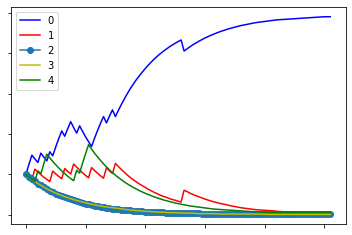

In [6]:
example = "0014044010001001404441000010010000000000000000000000100000000000000000000000000000000000000000000000000"
bins = 1024
alphabet = "01234"
rate = 4

cdf_, history = cdf(example, bins, alphabet, rate, keep_history=True)
hist = get_prob_history(history)
draw_plot(hist, alphabet, styles)

In [7]:
probs = probs_from_cdf(cdf_, bins)
occurs_count_prob_ = occurs_count_prob(example, alphabet)
neg_log_likelihood = sum(log(1/prob) for prob in probs.values())

print(probs)
print(occurs_count_prob_)
print(sum(probs.values()))
kl_divergence(probs, occurs_count_prob_), mean_code_len(len(example), probs), mean_code_len(len(example), occurs_count_prob_)

defaultdict(<class 'float'>, {'0': 0.9814453125, '1': 0.0009765625, '2': 0.0009765625, '3': 0.0009765625, '4': 0.01171875})
defaultdict(<class 'float'>, {'0': 0.8543689320388349, '1': 0.07766990291262135, '2': 0.0, '3': 0.0, '4': 0.06796116504854369})
0.99609375


(0.11121812932586224, 9.35206075565375, 53.11454273674443)

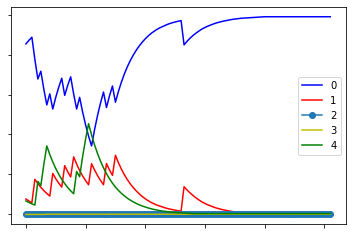

In [8]:
example = "0014044010001001404441000010010000000000000000000000100000000000000000000000000000000000000000000000000"
bins = 1024
alphabet = "01234"
rate = 3

cdf_, history = cdf(example, bins, alphabet, rate, method='avg', keep_history=True)
hist = get_prob_history(history)

draw_plot(hist, alphabet, styles)

In [9]:
probs = probs_from_cdf(cdf_, bins)
occurs_count_prob_ = occurs_count_prob(example, alphabet)
neg_log_likelihood = sum(log(1/prob) for prob in probs.values())
kl_divergence(probs, occurs_count_prob_), neg_log_likelihood

print(probs)
print(occurs_count_prob_)
print(sum(probs.values()))
kl_divergence(probs, occurs_count_prob_), mean_code_len(len(example), probs), mean_code_len(len(example), occurs_count_prob_)

defaultdict(<class 'float'>, {'0': 0.9892578125, '1': 0.0009765625, '2': 0.0009765625, '3': 0.0009765625, '4': 0.00390625})
defaultdict(<class 'float'>, {'0': 0.8543689320388349, '1': 0.07766990291262135, '2': 0.0, '3': 0.0, '4': 0.06796116504854369})
0.99609375


(0.12958588668124757, 5.4231743532165675, 53.11454273674443)